In [1]:
import os

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-4])
DATA_PATH = f'{ROOT_PATH}/Datasets/FitnessClub/fitness_class_2212.csv'

In [3]:
def compare_dataset_result(results, name = 'SVC'):
    
    print(f'[{name.upper()} RESULT FOR EACH DATASET]\n')
    for k, v in results.items():
        length = len('smote tomek') - len(k)    
        print(f'     [{k.upper()} TRAIN] {" "*length}[{k.upper()} TEST]')
        print(f'[ACC] {v["train"]["score"]}                {v["test"]["score"]}')
        print(f'[REC] {v["train"]["recall"]}                {v["test"]["recall"]}')
        print(f'[ F1] {v["train"]["f1"]}                {v["test"]["f1"]}')
        print(f'[AUC] {v["train"]["auc"]}                {v["test"]["auc"]}')

        print('-'*60)

        
def compute_metrics(train, test, results, model = None, name = 'original'):
    
    results[name] = {}
    results[name]['train'] = {}
    results[name]['test']  = {}
    results[name]['valid'] = {}
    
    model    = SVC(C = 5) if model == None else GradientBoostingClassifier(n_estimators = 20)
    tx , ty  = train
    model.fit(tx, ty)
    
    for dtype, data in zip(['train', 'test'], [train, test]): 
        
        x, y = data
        pred = model.predict(x)
        
        results[name][dtype]['score']  = f'{model.score(x, y):.2f}'
        results[name][dtype]['recall'] = f'{recall_score(pred, y):.2f}'
        results[name][dtype]['f1']     = f'{f1_score(pred, y):.2f}'
        results[name][dtype]['auc']    = f'{roc_auc_score(pred, y):.2f}'

    return results

In [4]:
df = pd.read_csv(DATA_PATH)
df.sample(3)

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
764,765,21,68.06,10,Fri,AM,Cycling,1
952,953,7,78.69,10,Fri,AM,HIIT,0
915,916,8,99.26,12,Sat,AM,Aqua,0


In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1480 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1480 non-null   int64  
 1   months_as_member  1480 non-null   int64  
 2   weight            1480 non-null   float64
 3   days_before       1480 non-null   object 
 4   day_of_week       1480 non-null   object 
 5   time              1480 non-null   object 
 6   category          1480 non-null   object 
 7   attended          1480 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 104.1+ KB


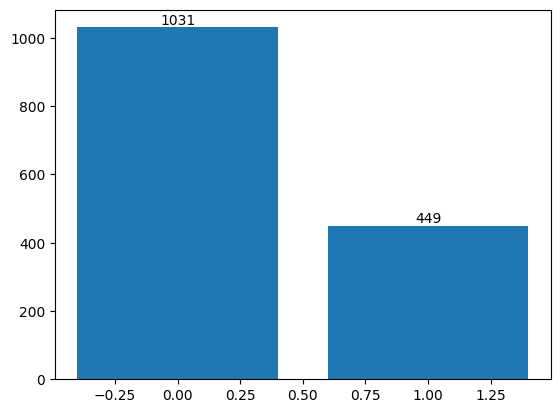

In [6]:
lb_cnt = dict(df.attended.value_counts())

plt.bar(lb_cnt.keys(), lb_cnt.values())
for k, v in lb_cnt.items():
    plt.text(k, v, v,
             ha = 'center', va = 'bottom')

In [7]:
le             = LabelEncoder()
df.days_before = df.days_before.apply(lambda x: int(x.replace('days', '')))
df.day_of_week = le.fit_transform(df.day_of_week)
df.time        = le.fit_transform(df.time)
df.category    = le.fit_transform(df.category)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1480 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1480 non-null   int64  
 1   months_as_member  1480 non-null   int64  
 2   weight            1480 non-null   float64
 3   days_before       1480 non-null   int64  
 4   day_of_week       1480 non-null   int64  
 5   time              1480 non-null   int64  
 6   category          1480 non-null   int64  
 7   attended          1480 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 104.1 KB


<Axes: >

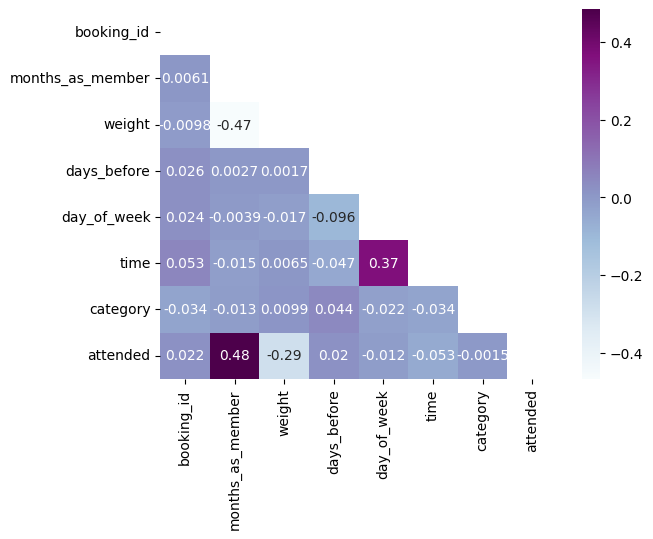

In [8]:
sns.heatmap(df.corr(), annot = True, mask = np.triu(df.corr()), cmap = 'BuPu')

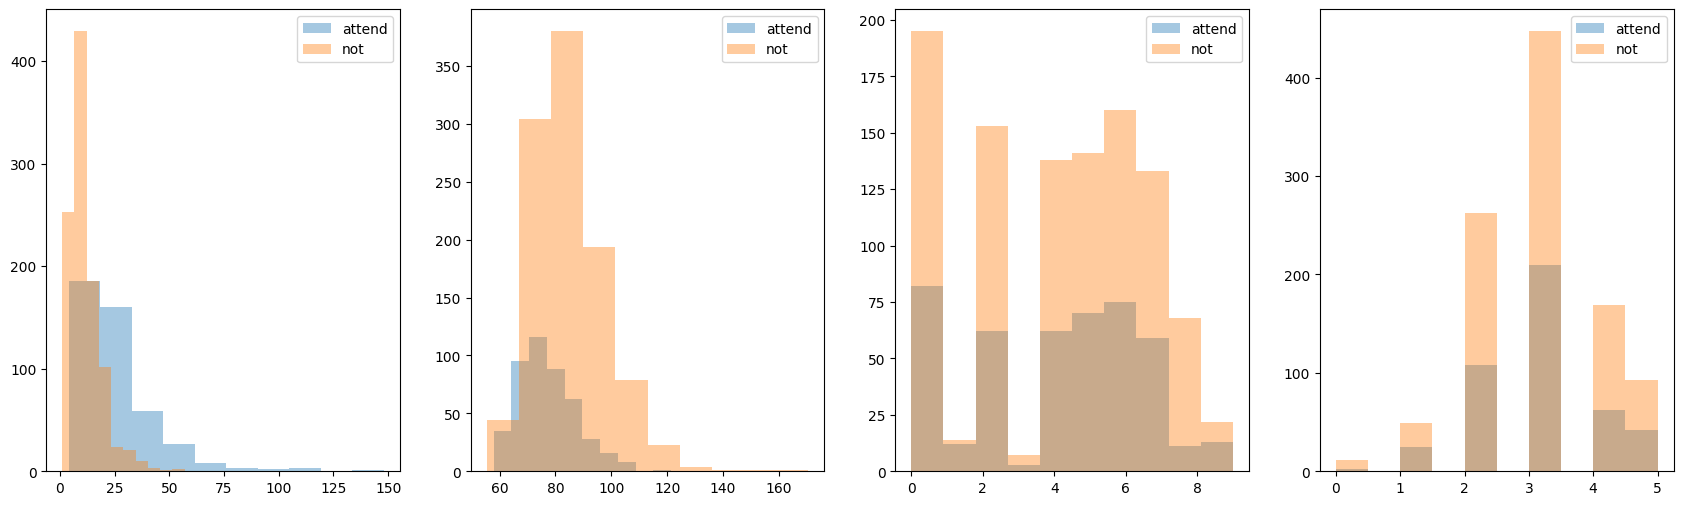

In [9]:
df_attend = df[df.attended == 1]
df_not    = df[df.attended == 0]

_, axes = plt.subplots(1, 4, figsize = (21, 6))

for ax, col in zip(axes, ['months_as_member', 'weight', 'day_of_week', 'category']):
    
    ax.hist(df_attend[col], alpha = 0.4, label = 'attend')
    ax.hist(df_not[col], alpha = 0.4, label = 'not')
    ax.legend()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9b01971630>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9b01971b70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9b019713f0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9b019720b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9b01972350>,
 'means': []}

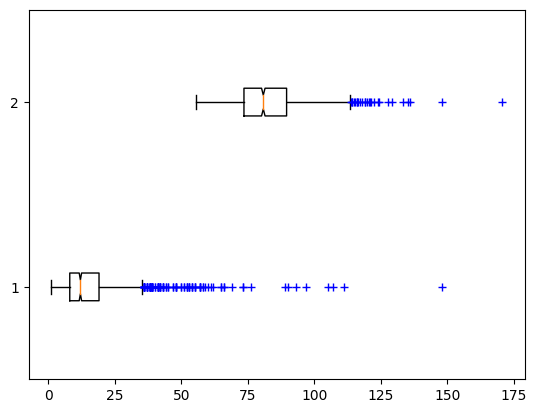

In [10]:
arr_    = np.array(df[['months_as_member', 'weight']])
plt.boxplot([arr_[:, 0], arr_[:, 1]], notch = True, vert = False, sym = 'b+')

In [11]:
Q1  = df[['months_as_member', 'weight']].quantile(q = 0.25)
Q3  = df[['months_as_member', 'weight']].quantile(q = 0.75)
IQR = Q3 - Q1

Q1, Q3, IQR

(months_as_member     8.00
 weight              73.49
 Name: 0.25, dtype: float64,
 months_as_member    19.00
 weight              89.52
 Name: 0.75, dtype: float64,
 months_as_member    11.00
 weight              16.03
 dtype: float64)

In [12]:
df.loc[df.query("`months_as_member` >80").index,'months_as_member'] = 80
df.loc[df.query("`weight` >130").index,'weight'] = 130

In [13]:
y = df.attended
x = np.array(df[['months_as_member', 'weight']])

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.1, stratify = y,
                                                    shuffle = True, random_state = 99)

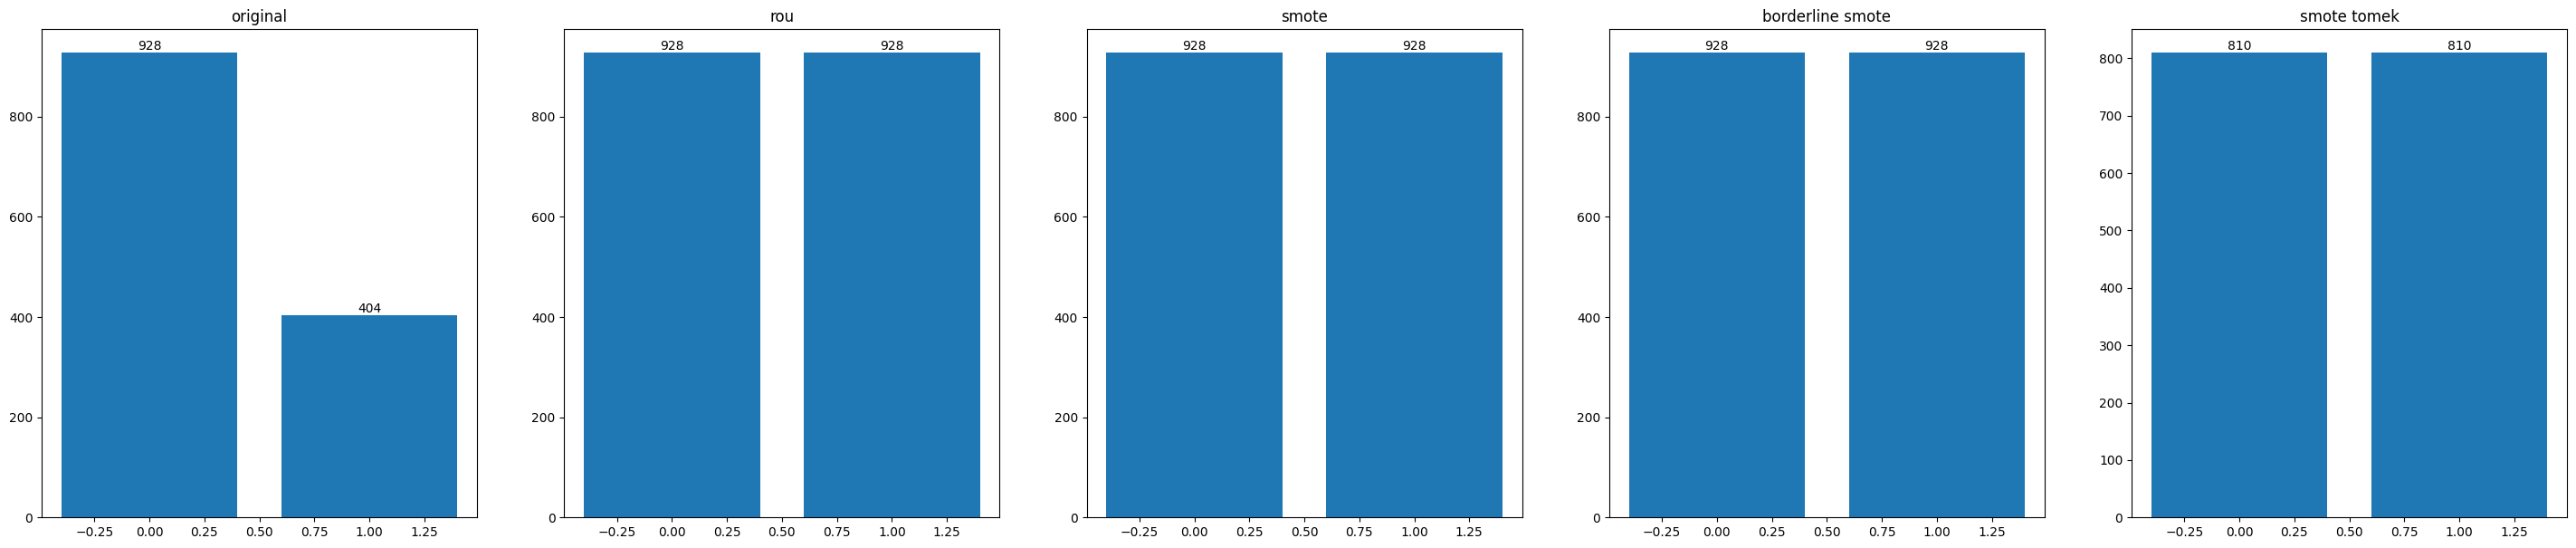

In [14]:
_, axes = plt.subplots(1, 5, figsize = (36, 7))

rou                  = RandomOverSampler()
smote                = SMOTE(k_neighbors = 4)
tomek                = SMOTETomek(random_state = 99)
border               = BorderlineSMOTE()

train_xr, train_yr   = rou.fit_resample(train_x, train_y)
train_xs, train_ys   = smote.fit_resample(train_x, train_y)
train_xb, train_yb   = border.fit_resample(train_x, train_y)
train_xst, train_yst = tomek.fit_resample(train_x, train_y)

datas  = [train_y, train_yr, train_ys, train_yb, train_yst]
titles = ['original', 'rou', 'smote', 'borderline smote', 'smote tomek'] 

for ax, data, title in zip(axes, datas, titles):
    
    lb_cnt = dict(data.value_counts())
    ax.bar(lb_cnt.keys(), lb_cnt.values())

    for k, v in lb_cnt.items():    
        ax.text(k, v, v,
                 ha = 'center', va = 'bottom')
        
    ax.set_title(title)

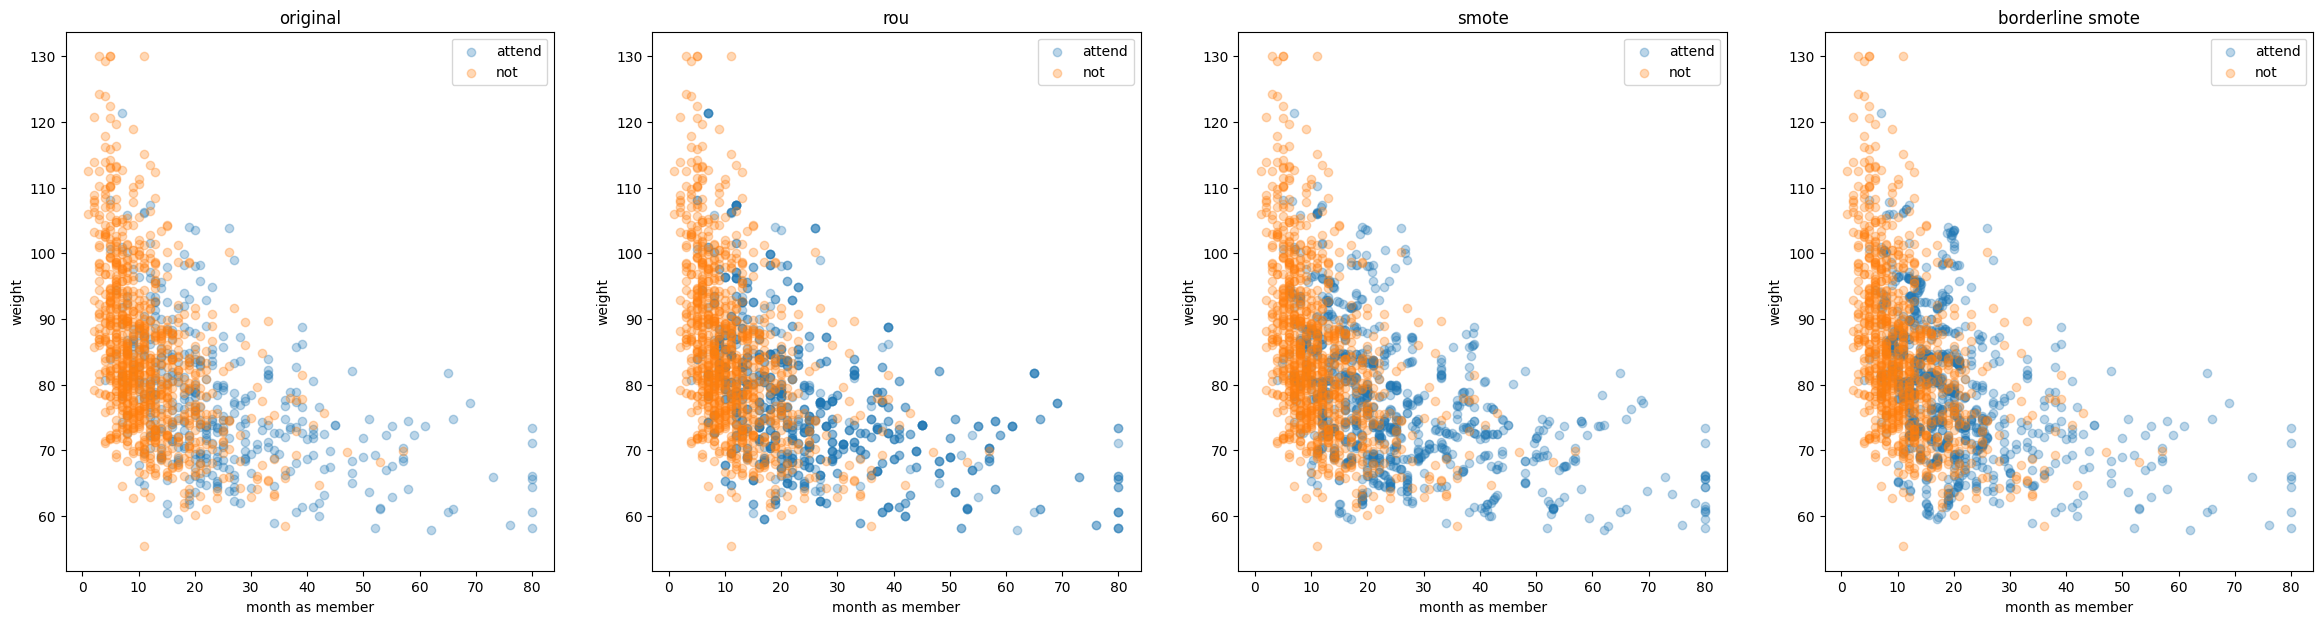

In [15]:
_, axes = plt.subplots(1, 4, figsize = (29, 7))
datas   = [
            [  train_x,   train_y],
            [ train_xr,  train_yr],
            [ train_xs,  train_ys], 
            [ train_xb,  train_yb], 
            [train_xst, train_yst],
          ]

titles  = ['original', 'rou', 'smote', 'borderline smote', 'smote tomek']

for ax, (data, label), title in zip(axes, datas, titles):
    
    attend = data[np.where(label == 1)]
    not_   = data[np.where(label == 0)]

    ax.scatter(attend[:, 0], attend[:, 1], alpha = 0.3, label = 'attend')
    ax.scatter(  not_[:, 0],   not_[:, 1], alpha = 0.3, label =    'not')
    ax.set_title(title)
    ax.set_xlabel('month as member')
    ax.set_ylabel('weight')
    ax.legend()

In [16]:
train       = [train_x, train_y]
test        = [test_x ,  test_y]

train_r     = [train_xr, train_yr]
train_s     = [train_xs, train_ys]
train_b     = [train_xb, train_yb]
train_st    = [train_xst, train_yst]

In [17]:
svc_results = {}
svc_results = compute_metrics(train   , test, svc_results)
svc_results = compute_metrics(train_r , test, svc_results, name = 'rou')
svc_results = compute_metrics(train_s , test, svc_results, name = 'smote')
svc_results = compute_metrics(train_b , test, svc_results, name = 'borderline')
svc_results = compute_metrics(train_st, test, svc_results, name = 'smote tomek')

In [18]:
gbc_results = {}
gbc_results = compute_metrics(train   , test, gbc_results, model = 'gbc')
gbc_results = compute_metrics(train_r , test, gbc_results, model = 'gbc', name = 'rou')
gbc_results = compute_metrics(train_s , test, gbc_results, model = 'gbc', name = 'smote')
gbc_results = compute_metrics(train_b , test, gbc_results, model = 'gbc', name = 'borderline')
gbc_results = compute_metrics(train_st, test, gbc_results, model = 'gbc', name = 'smote tomek')

In [19]:
compare_dataset_result(svc_results)

[SVC RESULT FOR EACH DATASET]

     [ORIGINAL TRAIN]    [ORIGINAL TEST]
[ACC] 0.77                0.78
[REC] 0.75                0.80
[ F1] 0.47                0.49
[AUC] 0.76                0.79
------------------------------------------------------------
     [ROU TRAIN]         [ROU TEST]
[ACC] 0.73                0.74
[REC] 0.74                0.55
[ F1] 0.73                0.64
[AUC] 0.73                0.71
------------------------------------------------------------
     [SMOTE TRAIN]       [SMOTE TEST]
[ACC] 0.73                0.74
[REC] 0.73                0.55
[ F1] 0.73                0.64
[AUC] 0.73                0.71
------------------------------------------------------------
     [BORDERLINE TRAIN]  [BORDERLINE TEST]
[ACC] 0.72                0.70
[REC] 0.69                0.51
[ F1] 0.73                0.64
[AUC] 0.72                0.71
------------------------------------------------------------
     [SMOTE TOMEK TRAIN] [SMOTE TOMEK TEST]
[ACC] 0.76                0

In [20]:
compare_dataset_result(gbc_results)

[SVC RESULT FOR EACH DATASET]

     [ORIGINAL TRAIN]    [ORIGINAL TEST]
[ACC] 0.80                0.76
[REC] 0.75                0.66
[ F1] 0.60                0.55
[AUC] 0.78                0.72
------------------------------------------------------------
     [ROU TRAIN]         [ROU TEST]
[ACC] 0.76                0.76
[REC] 0.77                0.57
[ F1] 0.76                0.66
[AUC] 0.76                0.73
------------------------------------------------------------
     [SMOTE TRAIN]       [SMOTE TEST]
[ACC] 0.77                0.78
[REC] 0.78                0.62
[ F1] 0.76                0.67
[AUC] 0.77                0.75
------------------------------------------------------------
     [BORDERLINE TRAIN]  [BORDERLINE TEST]
[ACC] 0.77                0.74
[REC] 0.74                0.55
[ F1] 0.79                0.64
[AUC] 0.78                0.71
------------------------------------------------------------
     [SMOTE TOMEK TRAIN] [SMOTE TOMEK TEST]
[ACC] 0.82                0